In [1]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils
from transformers import BertModel, TFBertModel
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import pandas as pd
from matplotlib import rcParams
import seaborn as sns
import numpy as np
from PIL import Image
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from transformers import AutoTokenizer
from mlxtend.plotting import plot_confusion_matrix

In [2]:
import kagglehub
import os
import shutil

# Download latest version
# for dataset see: https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets
path = kagglehub.dataset_download("emineyetm/fake-news-detection-datasets")

print("Path to dataset files:", path)

destination_path = "./news_detection"

os.makedirs(destination_path, exist_ok=True)

for file_name in os.listdir(path):
    shutil.move(os.path.join(path, file_name), destination_path)

fake_data = pd.read_csv(destination_path+"/News _dataset/Fake.csv")
real_data = pd.read_csv(destination_path+"/News _dataset/True.csv")

100%|██████████| 41.0M/41.0M [00:01<00:00, 26.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/emineyetm/fake-news-detection-datasets/versions/1


In [3]:
# add labels to news data
fake_data["label"]="fake"
real_data["label"]="real"

# concat real and fake news data
final_data= pd.concat([fake_data,real_data])

# reset index
final_data = final_data.sample(frac=1).reset_index(drop=True)

# drop columns with few contribution to the classification task
final_data.drop(["subject","date"], axis=1)

,title,text,label
0,Argentina says Russia wants more Argentine foo...,BUENOS AIRES (Reuters) - A Russian official ex...,real
1,Trump voter fraud official announces bid for K...,(Reuters) - Kansas Secretary of State Kris Kob...,real
2,Bulgaria's parliament speaker resigns 'to avoi...,SOFIA (Reuters) - Bulgaria s parliament speake...,real
3,"Bomb kills three, including senior police offi...","QUETTA, Pakistan (Reuters) - A suicide bomber ...",real
4,Exclusive: Atlantic City emergency fiscal mana...,(Reuters) - New Jersey taxpayers will owe $2.6...,real
...,...,...,...
44893,Trump Tweets His Dumbest Attack On FBI To Dat...,"On Friday, Donald Trump got himself amped up f...",fake
44894,Trump to meet with business leaders on infrast...,WASHINGTON (Reuters) - President Donald Trump ...,real
44895,THE DEMOCRAT WHO WROTE A PAPER About How Women...,The producers vs. the looters The man honeymoo...,fake
44896,MARINE ARRESTED FOR Complaining About Governme...,This is some pretty surreal stuff In the four ...,fake


In [4]:
# combine text and title as a whole text column
final_data["text"]=final_data["title"]+final_data["text"]

# use only text and label column in the data
final_data=final_data[["text","label"]]

# map real and fake news label as 1 and 0
final_data['label'] = final_data['label'].map({'real':1, 'fake':0})

# take a look at final data
final_data.head(10)

<ipython-input-4-62c154a05a6b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['label'] = final_data['label'].map({'real':1, 'fake':0})


,text,label
0,Argentina says Russia wants more Argentine foo...,1
1,Trump voter fraud official announces bid for K...,1
2,Bulgaria's parliament speaker resigns 'to avoi...,1
3,"Bomb kills three, including senior police offi...",1
4,Exclusive: Atlantic City emergency fiscal mana...,1
5,Thin-Skinned Trump Had A CRAZY On-Air Meltdow...,0
6,TODAY: LIST OF U.S. CITIES Where “DAY OF RAGE”...,0
7,Shooting Reported At Capitol; Gunman In Custo...,0
8,Kuwait says GCC to keep operating despite Qata...,1
9,WATCH: Black Police Officer Lays Waste To Rac...,0


In [5]:
# define the max length of token
# Tokenization max length
max_len=128

# Sample_size, maximum 20000
sample_size=1000

# sample the data to boost training
data_0 = final_data[final_data["label"] == 0].sample(n=sample_size, random_state=42)

data_1 = final_data[final_data["label"] == 1].sample(n=sample_size, random_state=42)

balanced_data = pd.concat([data_0, data_1]).reset_index(drop=True)

data_text = balanced_data["text"]
data_label = balanced_data["label"]

# split the data into training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(data_text, data_label, stratify = data_label, test_size = 0.2, random_state =42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1600,), (400,), (1600,), (400,))

In [6]:
# get pre-trained model
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [7]:
# tokenization function
def tokenize(X):

    X = bert_tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = 128,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X

In [8]:
# tokenize training and testing data
X_train_token = tokenize(X_train)
X_test_token = tokenize(X_test)

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Layer
from tensorflow.keras.models import Model

# bert layer
class BertLayer(Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = bert_model

    # get pooled output for classification
    def call(self, inputs):
        return self.bert(inputs)[1]

# define our own create model function
def create_model(bert_model, maxlen=100):
    # input for bert of shape (batch_size, maxlen)
    input_ids = Input(shape=(maxlen,), dtype=tf.int32, name="input_ids")
    # attention mask for bert model
    attention_mask = Input(shape=(maxlen,), dtype=tf.int32, name="attention_mask")

    # get the pooled output for bert layer
    bert_layer = BertLayer(bert_model)
    pooled_output = bert_layer({'input_ids': input_ids, 'attention_mask': attention_mask})

    # define our own layer for classification (fine-tune)
    # randomly dropout 50% of neurons while training to avoid overfit
    x = Dropout(0.5)(pooled_output)
    # transform and activate
    x = Dense(64, activation="tanh")(x)
    # dropout again
    x = Dropout(0.5)(x)
    # transform into probability from 0-1
    output = Dense(1, activation="sigmoid")(x)

    # return our model
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

# Create the model
# ablation study: change maxlen to 128
model = create_model(bert_model, maxlen=128)

# Display the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ attention_mask            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_ids (InputLayer)    │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer (BertLayer)    │ (None, 768)            │              0 │ attention_mask[0][0],  │
│                           │                        │                │ input_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 768)            │              0 │ bert_layer[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │         49,216 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │             65 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 49,281 (192.50 KB)

 Trainable params: 49,281 (192.50 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

# early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # or another metric you want to monitor
    patience=3,  # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True
)
# use ReduceLROnPlateau for changing learning rate while training for quicker converge
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,  # Reduce the learning rate by a factor of 0.1
    patience=3,  # Number of epochs with no improvement to wait before reducing the learning rate
    verbose=1,
    min_lr=1e-6  # Minimum learning rate
)

In [11]:
# optimizer, learning rate and other hyperparameters
lr = 1e-04
optimizer = Adam(learning_rate=lr, epsilon=1e-08, decay=0.01,clipnorm=1.0)

# compile our model before using it
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

# train and record history of training
history = model.fit(
    x={
        'input_ids': X_train_token['input_ids'],
        'attention_mask': X_train_token['attention_mask']
    },
    y=Y_train,
    epochs=20,
    batch_size=30,
    validation_data=(
        {
            'input_ids': X_test_token['input_ids'],
            'attention_mask': X_test_token['attention_mask']
        },
        Y_test
    ),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 640ms/step - accuracy: 0.5240 - loss: 0.7903 - val_accuracy: 0.5550 - val_loss: 0.6961 - learning_rate: 1.0000e-04
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 298ms/step - accuracy: 0.5056 - loss: 0.7904 - val_accuracy: 0.5775 - val_loss: 0.6938 - learning_rate: 1.0000e-04
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 255ms/step - accuracy: 0.5148 - loss: 0.7845 - val_accuracy: 0.5800 - val_loss: 0.6912 - learning_rate: 1.0000e-04
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 303ms/step - accuracy: 0.5226 - loss: 0.7718 - val_accuracy: 0.5875 - val_loss: 0.6876 - learning_rate: 1.0000e-04
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 261ms/step - accuracy: 0.5321 - loss: 0.7706 - val_accuracy: 0.5900 - val_loss: 0.6849 - learning_rate: 1.0000e-04
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 306ms/step - accuracy: 0.5403 - loss: 0.7657 - val_accuracy: 0.5900 - val_loss: 0.6841 - learning_rate: 1.0000e-04
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 267ms/step - accuracy: 0.53

In [12]:
# Make predictions
y_pred_proba = model.predict({
    'input_ids': X_test_token['input_ids'],
    'attention_mask': X_test_token['attention_mask']
})

# Convert probabilities to binary predictions
y_pred = np.where(y_pred_proba >= 0.5, 1, 0)

13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 908ms/step


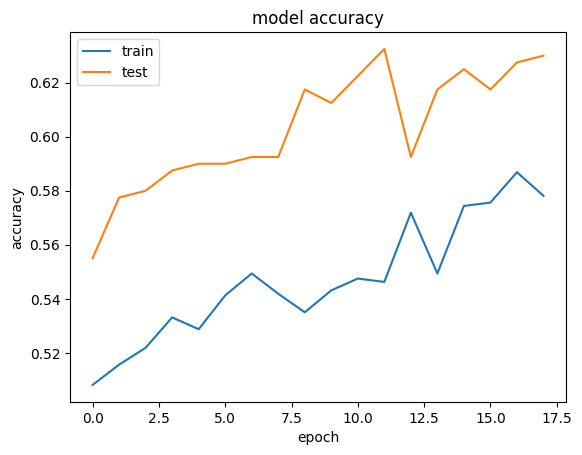

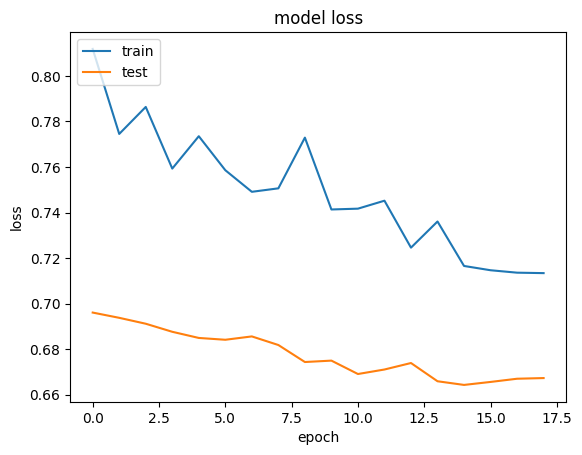

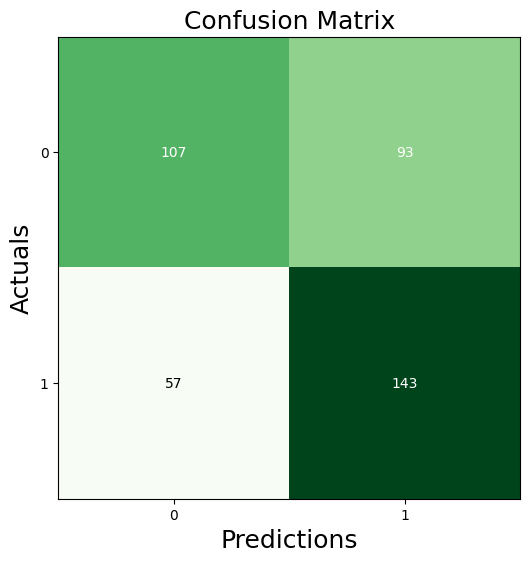

              precision    recall  f1-score   support

           0       0.65      0.54      0.59       200
           1       0.61      0.71      0.66       200

    accuracy                           0.62       400
   macro avg       0.63      0.62      0.62       400
weighted avg       0.63      0.62      0.62       400



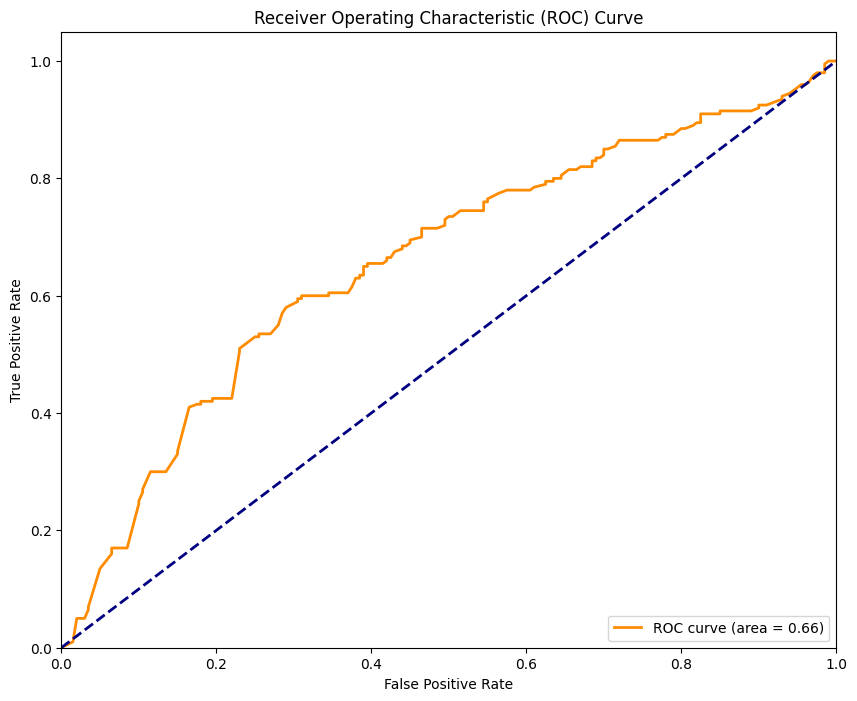

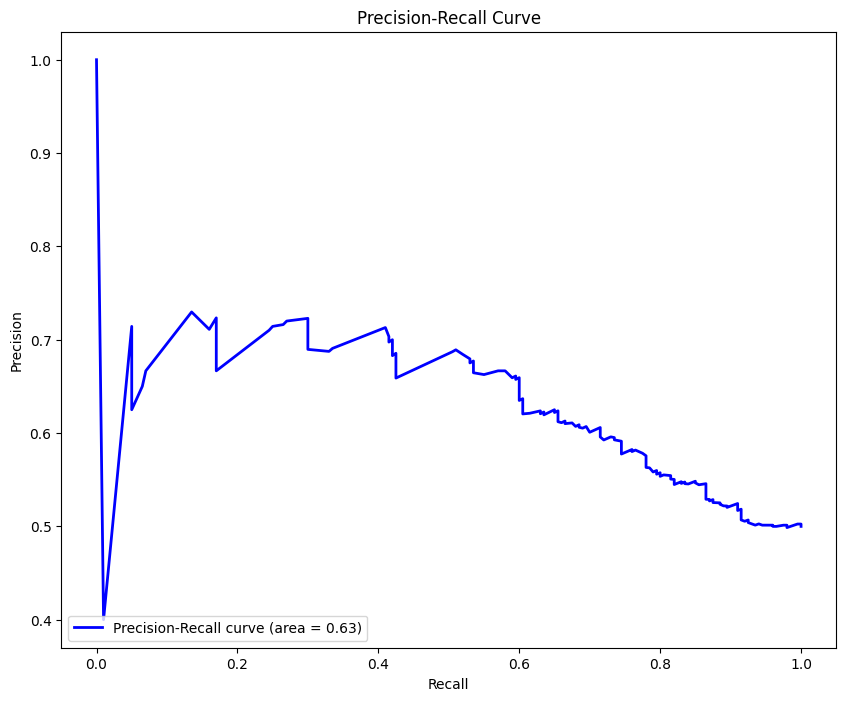

In [13]:
def plot(history,y_pred):
  # summarize history for accuracy
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  conf_matrix = confusion_matrix(Y_test,y_pred)
  fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix', fontsize=18)
  plt.show()

  print(classification_report(Y_test,y_pred))


  fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)  # Removed indexing on y_pred_prob
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(10,8))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  plt.show()

  precision, recall, thresholds = precision_recall_curve(Y_test, y_pred_proba)
  pr_auc = auc(recall, precision)

  plt.figure(figsize=(10,8))
  plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.legend(loc="lower left")
  plt.show()


plot(history.history, y_pred)